In [1]:
from __future__ import print_function
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2 
import matplotlib.pyplot as plt
import io
import base64
import os
from IPython.display import HTML
%matplotlib inline

In [15]:
import io

import base64

from IPython.display import HTML

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

from collections import defaultdict

import time

from PIL import Image

import keras

import keras.backend as K

from keras.models import Model

from keras.layers import *

from keras import optimizers

from keras.applications.resnet50 import ResNet50

from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras import backend as K

from keras.applications.inception_v3 import InceptionV3

from keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image

from skimage.transform import resize

import os

import numpy as np

import random

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from skimage.io import imread

# from scipy.misc import imread

from scipy.misc.pilutil import imread

from skimage.transform import resize

%matplotlib inline

# import skimage
# print (skimage)

Using TensorFlow backend.


In [2]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

In [3]:
cap = cv2.VideoCapture('got_scene.mp4')
ind = 0
frame_array = []

In [4]:
PATH = 'dataset/'

dirs = sorted(os.listdir(PATH))

#class name to id class
name_to_classid = {d:i for i,d in enumerate(dirs)}
#class id to class name
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: " + str(num_classes))

number of classes: 96


In [5]:
from glob import glob

In [6]:
img_paths = {c:[PATH + directory + "/" + img
            for img in sorted(os.listdir(PATH+directory))] 
             for directory,c in name_to_classid.items()}

In [7]:
# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# image path to class id 
path_to_id = {v:k for k,v in enumerate(all_images_path)}
# class id to image path
id_to_path = {v:k for k,v in path_to_id.items()}

/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


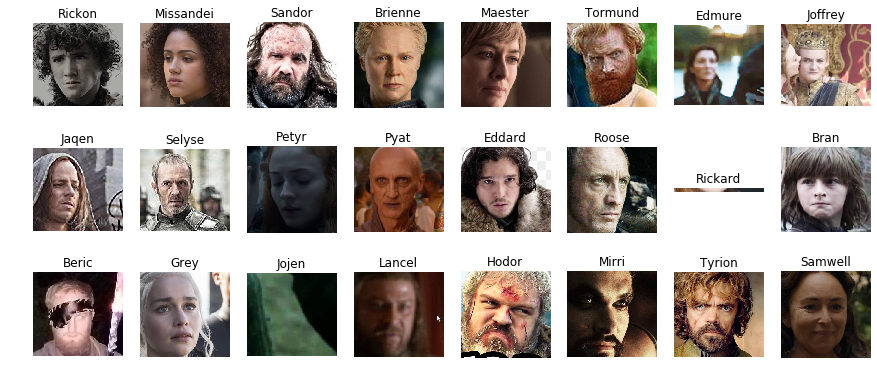

In [9]:
from skimage.io import imread
cols = 8
rows = 3
#pour allouer un cadre
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(all_images_path))
        #on place chacune des images sur le cadre
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(imread(all_images_path[random_index]))
        ax.set_title(all_images_path[random_index].split(os.path.sep)[1])
plt.show()

In [60]:
def most_sim(x, emb, topn=5, mode="cosine"):
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        print(x.shape, emb.shape)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id,sims[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [78]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')

def open_all_images(id_to_path):
    all_imgs = []
    for ind, path in enumerate(id_to_path.values()):
        all_imgs += [np.expand_dims(resize100(imread(path)),0)]
        if ind > 1000:
            break ;
    return np.vstack(all_imgs)

In [16]:
def get_model():
    inputs = Input((100, 100, 3), dtype='float32')
    
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(16, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 30,30
    
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 15,15
    
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = MaxPool2D((2,2))(x) # 8,8
    
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = Conv2D(128, 3, activation="relu", padding="same")(x)
#     x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = Flatten()(x)
    
    x = Dropout(0.2)(x)
    x = Dense(40, activation="tanh")(x)
    x = Dropout(0.2)(x)
    x = Dense(64)(x)
    
    base_model = Model(inputs=inputs, outputs = x)
    return base_model

In [17]:
shared_conv2 = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

In [20]:
def cosine_triplet_loss(X):
    _alpha = 0.5
    positive_sim, negative_sim = X
    
    # batch loss
    losses = K.maximum(0.0, negative_sim - positive_sim + _alpha)
    
    return K.mean(losses)

In [21]:
anchor = Input((100, 100, 3), name='anchor')
positive = Input((100, 100, 3), name='positive')
negative = Input((100, 100, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

pos_sim = Dot(axes=-1, normalize=True)([a,p])
neg_sim = Dot(axes=-1, normalize=True)([a,n])

loss = Lambda(cosine_triplet_loss,
              output_shape=(1,))(
             [pos_sim,neg_sim])

model_triplet = Model(
    inputs=[anchor, positive, negative],
    outputs=loss)

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_triplet.compile(loss=identity_loss, optimizer=opt, metrics=['accuracy'])

In [24]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((1002, 100, 100, 3), '240.48Mo')

In [72]:
emb = shared_conv2.predict(all_imgs)
print (emb.shape, emb[0].shape)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)
print (emb.shape, emb[0].shape)

(1002, 64) (64,)
(1002, 64) (64,)


In [ ]:
shared_conv2.predict(all_imgs)

In [26]:
def select_suggest(img_idx, k=3):
    plt.figure(figsize=(16, 9))
    plt.subplot(3, 5, 1)
    plt.title(id_to_path[img_idx].split(os.path.sep)[1])
    plt.imshow((all_imgs[img_idx] + mean) / 255)
    plt.axis('off')
    test = most_sim(emb[img_idx], emb, topn=15+1)
    test = test[1:]
    index = 0
    for i, id in enumerate(test):
        if i < 4:
            plt.subplot(3, 5, i + 2)
            plt.title('sim {}'.format(id_to_path[id[0]].split(os.path.sep)[1]))
            plt.imshow((all_imgs[id[0]] + mean) / 255)
            plt.axis('off')
            index += 1
        else:
            break ;
    plt.show()

In [27]:
from skimage.io import imread
from skimage.transform import resize

In [28]:
emb = np.load('emb.npy')

In [29]:
most_sim(emb[0], emb, topn=1)[0][0]

(64,)


0

In [30]:
def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')

In [68]:
all_imgs.shape

(1002, 100, 100, 3)

In [84]:
crop1 = np.expand_dims(resize100(crop_img), axis=0)
crop2 = np.expand_dims(resize100(crop_img), axis=0)
cropLst = []
cropLst += [crop1]
cropLst += [crop2]
cropLSt = np.vstack(cropLst)
# crop2 = np.expand_dims(crop2, axis=0)
# cropLst.shape

In [85]:
shared_conv2.predict(cropLst).shape

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[[12.      , 22.      , 26.      ],
         [12.      , 21.      , 26.      ],
         [12.      , 21.      , 26.275   ],
         ...,
         [ 4.72    , 15.72    , 28.441375],
         ...

In [80]:
test = shared_conv2.predict(crop2) / np.linalg.norm(shared_conv2.predict(crop2), axis=-1, keepdims=True)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (100, 100, 3)

In [49]:
shared_conv2.predict(crop2)

array([[ 0.07479206,  0.0181518 ,  0.0276436 ,  0.08602594, -0.00290103,
        -0.07476369, -0.09443644, -0.10297173, -0.27062297,  0.19224352,
        -0.04131895,  0.0291234 ,  0.14325781, -0.03203254,  0.01128406,
        -0.15570536,  0.01333341, -0.04006959, -0.01464538,  0.10192782,
        -0.11650999, -0.11697959,  0.0035409 ,  0.08500798, -0.0252817 ,
         0.10211681,  0.02361581, -0.05710481,  0.05468991, -0.08090816,
         0.09477146,  0.1269748 ,  0.06393166,  0.06649705, -0.05610325,
         0.02924482,  0.04142712,  0.0259553 ,  0.10511792, -0.01549328,
        -0.10565489, -0.06080856, -0.08906244, -0.00285026, -0.1337161 ,
        -0.02921751, -0.14035057, -0.1417908 ,  0.05057954,  0.06903648,
        -0.02737641, -0.01067874, -0.14086202, -0.11324222,  0.0090437 ,
        -0.17449911, -0.07148167, -0.06849577,  0.09839535, -0.11041792,
         0.04452854, -0.03248747,  0.05497721,  0.02038708]],
      dtype=float32)

In [61]:
most_sim(emb[0], emb, topn=2)

(64,) (1002, 64)


[(0, 1.0), (18, 0.95973307)]

In [51]:
emb[0].shape

(64,)

In [34]:
# print (id_to_path[most_sim(resize100(crop_img), emb, topn=1)[0][0]].split(os.path.sep)[1])

In [35]:
# display(crop_img)

In [36]:
print (type(emb))

<class 'numpy.ndarray'>


In [37]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [38]:
while(cap.isOpened()):
    ret, frame = cap.read()

#     try:
#         gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        crop_img = frame[y-30:y+h+30, x-20:x+w+50]
        print (id_to_path[most_sim(crop_img, emb, topn=1)[0][0]].split(os.path.sep)[1])
        cv2.putText(frame, id_to_path[most_sim(crop_img, emb, topn=1)[0][0]].split(os.path.sep)[1], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
#             cv2.putText(frame, , (x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
#             display(frame)
        frame_array.append(frame)
#             crop_img = img[y-30:y+h+30, x-20:x+w+50]
#             cv.imwrite('dataset/{}'.format(file.split(os.path.sep)[-1]),crop_img)
#     except Exception as ex:
#         print(ex)

cap.release()
cv2.destroyAllWindows()

(301, 311, 3)


ValueError: shapes (1002,64) and (301,311,3) not aligned: 64 (dim 1) != 311 (dim 1)

In [12]:
# print (frame_array)

[array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 0,  2,  0],
        [ 0,  2,  0],
        [ 0,  2,  0]],

       ...,

       [[10, 13, 13],
        [10, 13, 13],
        [10, 13, 13],
        ...,
        [ 5, 22, 31],
        [ 5, 22, 31],
        [ 5, 22, 31]],

       [[10, 13, 13],
        [10, 13, 13],
        [10, 13, 13],
        ...,
        [ 5, 22, 31],
        [ 5, 22, 31],
        [ 5, 22, 31]],

       [[10, 13, 13],
        [10, 13, 13],
        [10, 13, 13],
        ...,
        [ 5, 22, 31],
        [ 5, 22, 31],
        [ 5, 22, 31]]], dtype=uint8), array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0

In [13]:
len(frame_array)

0

In [31]:
fps = 25.0
print(frame_array[0].shape)
height, width, layers = frame_array[0].shape
size = (width,height)
out = cv2.VideoWriter('video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
#     display(frame_array[i])
out.release()

IndexError: list index out of range

In [ ]:
# vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
# success,image = vidcap.read()
# count = 0
# while success:
#     print ('hello')
#     #     cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     print('Read a new frame: ', success)
#     count += 1

In [18]:
def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')

def open_all_images(id_to_path):
    all_imgs = []
    for ind, path in enumerate(id_to_path.values()):
        all_imgs += [np.expand_dims(resize100(imread(path)),0)]
        if ind > 1000:
            break ;
    return np.vstack(all_imgs)

In [19]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((1002, 100, 100, 3), '240.48Mo')

In [ ]:
video = io.open('video.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="560" height="315" controls> 
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [141]:
import numpy as np
import cv2 as cv

cap = cv.VideoCapture('got_scene.mp4')
ind = 0
frame_array = []
while(cap.isOpened()):
    ret, frame = cap.read()

    try:
#         gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(frame, cv.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
#             display(frame)
            frame_array.append(frame)
#             crop_img = img[y-30:y+h+30, x-20:x+w+50]
#             cv.imwrite('dataset/{}'.format(file.split(os.path.sep)[-1]),crop_img)
    except:
        break ;
        print ("Not processed {}".format(file))

cap.release()
cv.destroyAllWindows()